In [1]:
!pip install transformers optuna wandb ray[tune] torch torchvision torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
from huggingface_hub import notebook_login

notebook_login()

# Dataset and Tokenizer Preparation

In [4]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [6]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load a sample dataset (e.g., GLUE MRPC)
dataset = load_dataset("glue", "mrpc")

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence1"], examples["sentence2"], truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define hyperparameter search space using Optuna
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64, 128]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        "warmup_steps": trial.suggest_int("warmup_steps", 0, 1000),
        "adam_beta1": trial.suggest_float("adam_beta1", 0.85, 0.95),
        "adam_beta2": trial.suggest_float("adam_beta2", 0.95, 0.999),
        "adam_epsilon": trial.suggest_float("adam_epsilon", 1e-8, 1e-6),
    }

# Model initialization function
def model_init():
    return AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define the compute metrics function
def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'eval_accuracy': acc,  # Use eval_accuracy to match the expected key
        'eval_f1': f1,
        'eval_precision': precision,
        'eval_recall': recall
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    fp16=True,  # Mixed precision training
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",  # Updated to match the key
    greater_is_better=True,
)

# Initialize the Trainer
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Define the compute objective function
def compute_objective(metrics):
    return metrics['eval_accuracy'], -metrics['eval_loss']  # Updated keys to 'eval_accuracy'

# Perform hyperparameter search
best_trials = trainer.hyperparameter_search(
    direction=["maximize", "minimize"],
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=30,
    compute_objective=compute_objective,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-08-17 17:14:54,049] A new study created in memory with name: no-name-1dc12001-8aa9-4d27-92c4-5d23c3b6da75
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▂▄▅▇█
train/global_step,▁▂▄▅▇█
train/grad_norm,▆▃█▁▆


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.623000,0.631814,0.683824,0.812227,0.683824,1.000000
2,0.656100,0.625009,0.683824,0.812227,0.683824,1.000000
3,0.609600,0.605749,0.698529,0.819383,0.694030,1.000000
4,0.604700,0.572884,0.718137,0.826546,0.713542,0.982079


[I 2024-08-17 17:17:29,793] Trial 0 finished with values: [0.7181372549019608, -0.5728837847709656] and parameters: {'learning_rate': 4.118339785565431e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 4, 'weight_decay': 0.26376794248191376, 'warmup_steps': 950, 'adam_beta1': 0.8781879039544453, 'adam_beta2': 0.9797709985105187, 'adam_epsilon': 4.770765310151834e-07}. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▁▄█
eval/f1,▁▁▄█
eval/loss,█▇▅▁
eval/precision,▁▁▃█
eval/recall,███▁
eval/runtime,▂▁█▄
eval/samples_per_second,▇█▁▅
eval/steps_per_second,▇█▁▅
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,▁▇▂▁▃▇▅▃▄▂▃▄▄▃▃▄▇▅▁▃▅▂▂▆▁▄█▄▃▂▄▄▄▃▅▃▃▃▂▁


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.638900,0.633866,0.683824,0.812227,0.683824,1.000000
2,0.646000,0.632774,0.683824,0.812227,0.683824,1.000000
3,0.644400,0.631079,0.683824,0.812227,0.683824,1.000000


[I 2024-08-17 17:20:17,203] Trial 1 finished with values: [0.6838235294117647, -0.6310789585113525] and parameters: {'learning_rate': 1.3822527080660204e-06, 'per_device_train_batch_size': 128, 'num_train_epochs': 3, 'weight_decay': 0.07483969270760625, 'warmup_steps': 240, 'adam_beta1': 0.9338721868620969, 'adam_beta2': 0.9726610099601721, 'adam_epsilon': 5.799327781624079e-08}. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▁▁
eval/f1,▁▁▁
eval/loss,█▅▁
eval/precision,▁▁▁
eval/recall,▁▁▁
eval/runtime,▁▆█
eval/samples_per_second,█▃▁
eval/steps_per_second,█▃▁
train/epoch,▁▂▃▃▄▅▅▆▆▇██
train/global_step,▁▂▃▃▄▅▅▆▆▇██
train/grad_norm,▁▃▅▃█▃▁▂


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.619500,0.627992,0.683824,0.812227,0.683824,1.000000
2,0.622500,0.597822,0.710784,0.825444,0.702771,1.000000
3,0.536200,0.527837,0.754902,0.840256,0.757925,0.942652
4,0.524200,0.494555,0.781863,0.851913,0.795031,0.917563


[I 2024-08-17 17:23:59,064] Trial 2 finished with values: [0.7818627450980392, -0.49455514550209045] and parameters: {'learning_rate': 9.581848577824506e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 4, 'weight_decay': 0.26016556090758075, 'warmup_steps': 815, 'adam_beta1': 0.9107376339877128, 'adam_beta2': 0.9776396348176597, 'adam_epsilon': 6.467848437745865e-07}. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▃▆█
eval/f1,▁▃▆█
eval/loss,█▆▃▁
eval/precision,▁▂▆█
eval/recall,██▃▁
eval/runtime,█▆▁▃
eval/samples_per_second,▁▃█▅
eval/steps_per_second,▁▃█▅
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,▁█▂▁▃█▆▂▄▁▃▄▃▂▂▄▇▅▁▃▅▂▂▅▂▄▆▂▂▃▃▃▃▄▃▃▃▄▆▃


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.636900,0.632757,0.683824,0.812227,0.683824,1.000000
2,0.636900,0.628186,0.683824,0.812227,0.683824,1.000000
3,0.625000,0.619465,0.683824,0.812227,0.683824,1.000000


[I 2024-08-17 17:27:46,796] Trial 3 finished with values: [0.6838235294117647, -0.6194649338722229] and parameters: {'learning_rate': 3.5681199085414747e-06, 'per_device_train_batch_size': 64, 'num_train_epochs': 3, 'weight_decay': 0.17934320085696323, 'warmup_steps': 424, 'adam_beta1': 0.944413963421004, 'adam_beta2': 0.9956507057778214, 'adam_epsilon': 9.89682270267017e-07}. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▁▁
eval/f1,▁▁▁
eval/loss,█▆▁
eval/precision,▁▁▁
eval/recall,▁▁▁
eval/runtime,▅▁█
eval/samples_per_second,▃█▁
eval/steps_per_second,▃█▁
train/epoch,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇███
train/global_step,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇███
train/grad_norm,▅▂▆▁▅▁█▄▃▃▄▃▂▁▂▃▁


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.630200,0.592575,0.705882,0.822485,0.700252,0.996416
2,0.464100,0.493142,0.779412,0.855769,0.773913,0.956989


[I 2024-08-17 17:29:59,625] Trial 4 finished with values: [0.7794117647058824, -0.4931420683860779] and parameters: {'learning_rate': 1.3535863845359953e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.07374936641211507, 'warmup_steps': 742, 'adam_beta1': 0.858126096820504, 'adam_beta2': 0.9586894510415558, 'adam_epsilon': 2.0444298016756184e-07}. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
train/grad_norm,▁▂▄▆▂▃▁▅▁▃▆▂▁▅▂▅▂▄█▂▄▂▂▄▃▃▃▃▂▃▄▃▄▆▅▅▆▅█▅


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.631300,0.623126,0.683824,0.812227,0.683824,1.000000
2,0.591300,0.569158,0.710784,0.822289,0.709091,0.978495
3,0.509800,0.501211,0.776961,0.849587,0.788344,0.921147


[I 2024-08-17 17:32:29,085] Trial 5 finished with values: [0.7769607843137255, -0.5012105107307434] and parameters: {'learning_rate': 1.7014171128310554e-05, 'per_device_train_batch_size': 64, 'num_train_epochs': 3, 'weight_decay': 0.23086106504524295, 'warmup_steps': 264, 'adam_beta1': 0.9453461409208453, 'adam_beta2': 0.9525897546659557, 'adam_epsilon': 3.4397981219870016e-07}. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▃█
eval/f1,▁▃█
eval/loss,█▅▁
eval/precision,▁▃█
eval/recall,█▆▁
eval/runtime,▃▁█
eval/samples_per_second,▆█▁
eval/steps_per_second,▆█▁
train/epoch,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇███
train/global_step,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇███
train/grad_norm,▇▃█▂▅▁█▃▄▇▄▂▄▄▅▆▅


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.638600,0.632875,0.683824,0.812227,0.683824,1.000000
2,0.643800,0.629160,0.683824,0.812227,0.683824,1.000000
3,0.637600,0.622441,0.683824,0.812227,0.683824,1.000000


[I 2024-08-17 17:34:05,017] Trial 6 finished with values: [0.6838235294117647, -0.6224406957626343] and parameters: {'learning_rate': 2.0687130104840723e-05, 'per_device_train_batch_size': 128, 'num_train_epochs': 3, 'weight_decay': 0.2266209764312428, 'warmup_steps': 963, 'adam_beta1': 0.8728752686845095, 'adam_beta2': 0.9776277741482087, 'adam_epsilon': 2.537780370321811e-07}. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▁▁
eval/f1,▁▁▁
eval/loss,█▆▁
eval/precision,▁▁▁
eval/recall,▁▁▁
eval/runtime,▁█▄
eval/samples_per_second,█▁▅
eval/steps_per_second,█▁▅
train/epoch,▁▂▃▃▄▅▅▆▆▇██
train/global_step,▁▂▃▃▄▅▅▆▆▇██
train/grad_norm,▁▃▅▃█▃▁▂


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.548200,0.518942,0.781863,0.859400,0.768362,0.974910
2,0.436500,0.452725,0.801471,0.864322,0.811321,0.924731
3,0.380800,0.457086,0.813725,0.876623,0.801187,0.967742


[I 2024-08-17 17:35:46,687] Trial 7 finished with values: [0.8137254901960784, -0.4570862352848053] and parameters: {'learning_rate': 1.895171965499263e-05, 'per_device_train_batch_size': 64, 'num_train_epochs': 3, 'weight_decay': 0.2618385177615284, 'warmup_steps': 2, 'adam_beta1': 0.8910196866111151, 'adam_beta2': 0.9533054384261485, 'adam_epsilon': 4.489915581356935e-07}. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅█
eval/f1,▁▃█
eval/loss,█▁▁
eval/precision,▁█▆
eval/recall,█▁▇
eval/runtime,▁█▅
eval/samples_per_second,█▁▄
eval/steps_per_second,█▁▄
train/epoch,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇███
train/global_step,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇███
train/grad_norm,▃▁▂▁▂▂▂▃▃▂▃▄▃▄▅█▄


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.575100,0.516589,0.769608,0.846405,0.777778,0.928315
2,0.432000,0.381254,0.823529,0.880000,0.822430,0.946237
3,0.253100,0.375909,0.850490,0.893543,0.870748,0.917563
4,0.129300,0.459946,0.862745,0.902098,0.880546,0.924731
5,0.051700,0.517843,0.865196,0.904679,0.875839,0.935484


[I 2024-08-17 17:38:11,546] Trial 8 finished with values: [0.8651960784313726, -0.51784348487854] and parameters: {'learning_rate': 3.722716461837092e-05, 'per_device_train_batch_size': 64, 'num_train_epochs': 5, 'weight_decay': 0.0524292158501917, 'warmup_steps': 81, 'adam_beta1': 0.9301979228239061, 'adam_beta2': 0.9960105651477281, 'adam_epsilon': 5.261004882305294e-07}. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅▇██
eval/f1,▁▅▇██
eval/loss,█▁▁▅█
eval/precision,▁▄▇██
eval/recall,▄█▁▃▅
eval/runtime,█▄▁▅▄
eval/samples_per_second,▁▄█▃▄
eval/steps_per_second,▁▄█▃▄
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
train/grad_norm,▂▁▂▁▁▂▂▅▄▄▃▂▃▅▂▅▃▃▂▄▄▃▄▆█▃▁▁▁


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.610100,0.612310,0.688725,0.814599,0.687192,1.000000
2,0.562000,0.520512,0.757353,0.831919,0.790323,0.878136
3,0.428300,0.460064,0.823529,0.882736,0.808955,0.971326
4,0.349600,0.418026,0.833333,0.884354,0.841424,0.931900
5,0.154400,0.444557,0.840686,0.889267,0.847403,0.935484


[I 2024-08-17 17:41:05,661] Trial 9 finished with values: [0.8406862745098039, -0.44455745816230774] and parameters: {'learning_rate': 1.3620355058286144e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.08580047449414488, 'warmup_steps': 373, 'adam_beta1': 0.9454178792245931, 'adam_beta2': 0.9719137109853347, 'adam_epsilon': 9.885785491580137e-07}. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▄▇██
eval/f1,▁▃▇██
eval/loss,█▅▃▁▂
eval/precision,▁▆▆██
eval/recall,█▁▆▄▄
eval/runtime,▅▁▂▁█
eval/samples_per_second,▄█▆█▁
eval/steps_per_second,▄█▆█▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,▁▄▁▂▄▁▁▁▂▂▁▁▂▃▂▃▃▄▂▂▂▄▂▄▂▃▃▄▅▃▄▄█▄▂▂▄▄▇▄


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.638200,0.631367,0.683824,0.812227,0.683824,1.000000


[W 2024-08-17 17:41:39,751] Trial 10 failed with parameters: {'learning_rate': 4.430063139865743e-05, 'per_device_train_batch_size': 128, 'num_train_epochs': 4, 'weight_decay': 0.19235299327019909, 'warmup_steps': 928, 'adam_beta1': 0.8848491982870554, 'adam_beta2': 0.9813990432150074, 'adam_epsilon': 8.932868143681129e-07} because of the following error: RuntimeError('[enforce fail at inline_container.cc:595] . unexpected pos 506098688 vs 506098576').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 628, in save
    _save(obj, opened_zipfile, pickle_module, pickle_protocol, _disable_byteorder_record)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 862, in _save
    zip_file.write_record(name, storage, num_bytes)
RuntimeError: [enforce fail at inline_container.cc:764] . PytorchStreamWriter failed writing file data/200: file write failed

During handling of the above exception, another exceptio

RuntimeError: [enforce fail at inline_container.cc:595] . unexpected pos 506098688 vs 506098576

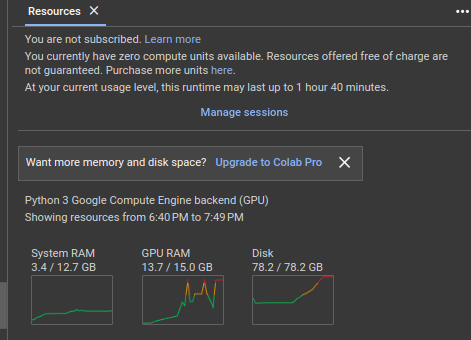

# Model Initialization Function

In [ ]:
from transformers import AutoModelForSequenceClassification

def model_init():
    return AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


# Training Arguments Setup

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    fp16=True,  # Mixed precision for faster training
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

# Initialize Trainer and Perform Hyperparameter Search

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=50,
    compute_objective=lambda metrics: metrics["eval_accuracy"],
)

# Distributed Training

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=best_trial.hyperparameters['learning_rate'],
    num_train_epochs=int(best_trial.hyperparameters['num_train_epochs']),
    weight_decay=best_trial.hyperparameters['weight_decay'],
    logging_dir='./logs',
    logging_steps=10,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    # Enable Distributed Data Parallel (DDP)
    ddp_find_unused_parameters=False,
)

# Train Final Model with Best Hyperparameters

In [ ]:
best_model = model_init()
best_trainer = Trainer(
    model=best_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

best_trainer.train()

In [ ]:
best_trainer.push_to_hub("bert-mrpc-optimized")

In [ ]:
import wandb

wandb.init(project="transformer-hpo", entity="wandb")

In [ ]:
trainer.add_callback(transformers.integrations.WandbCallback)